<a href="https://colab.research.google.com/github/youssefdarwish37/AmericanSignLanguage/blob/main/asl_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from keras.backend import flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow_datasets as tfds


from keras.layers.core.spatial_dropout import Dropout
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory


# data reading and splitting


In [ ]:
files = []
images=[]
import cv2
for dirname, dirnames, filenames in os.walk('/content/gdrive/MyDrive/asl/asl',topdown = True):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
files = list(dict.fromkeys(files))
files= sorted(files)
labels = []
for s in files:
  im = image.imread(s)
  im = cv2.resize(im, (224,224), interpolation = cv2.INTER_AREA)
  images.append(im)

  s=s.split("_")
  labels.append(s[1])




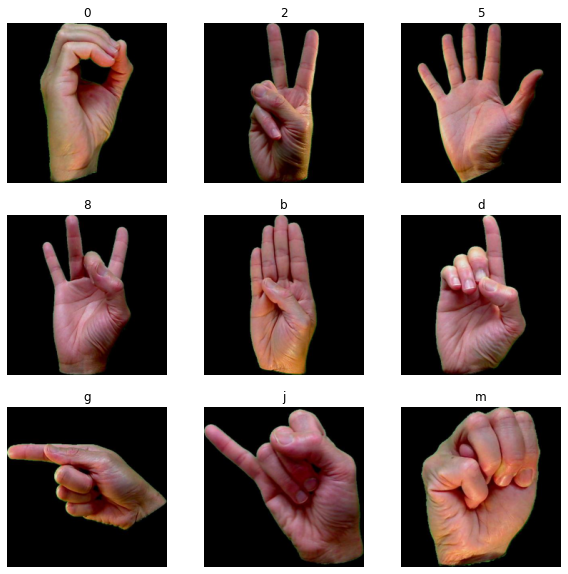

In [ ]:
plt.figure(figsize=(10, 10))  
for i in range (9):
  ax = plt.subplot(3, 3, i+1) 
  plt.imshow(images[i*69])
  plt.title(labels[i*69])
  plt.axis('off')
  
plt.show()

In [ ]:
# tf.compat.v1.disable_eager_execution()

# def data_augmenter(x):
#   shape = x.shape

#   x = tf.compat.v1.placeholder(dtype = tf.float16, shape = shape)

#   flip_2 = tf.image.flip_up_down(x)
  
#   flip_3 = tf.image.flip_left_right(x)

#   plt.imshow(flip_3.numpy())
#   plt.show()
#   # print(flip_3)

#   # plt.imshow(flip_2[2])
#   # plt.show()
#   return flip_2,flip_3

In [ ]:
from scipy import ndimage



# def rotate_90(x):
#   img_45 = ndimage.rotate(x, 90, reshape=False) 
#   return img_45

In [ ]:
def rotate_45(x):
  img_45 = ndimage.rotate(x, 45, reshape=False) 
  return img_45

In [ ]:
def flip(x):

  return np.fliplr(x)

In [ ]:

labels_augmented=[]
images_augmented=[]
for i in range(np.array(images).shape[0]):
  #adding normal image
  images_augmented.append(images[i])
  labels_augmented.append(labels[i])

  #adding flipped image
  image_flip=flip(images[i])
  images_augmented.append(image_flip)
  labels_augmented.append(labels[i])

  #adding rotated image
  image_rot_45=rotate_45(images[i])
  images_augmented.append(image_rot_45)
  labels_augmented.append(labels[i])








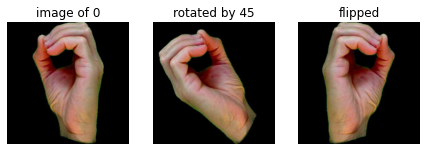

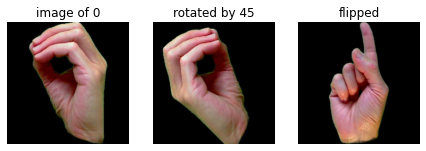

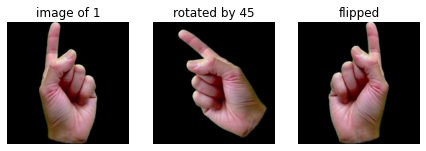

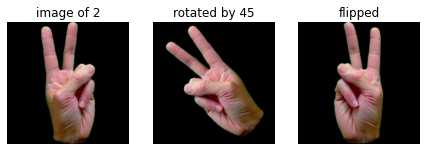

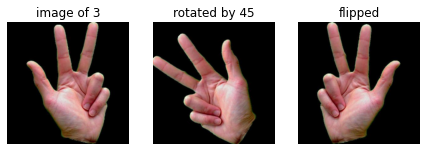

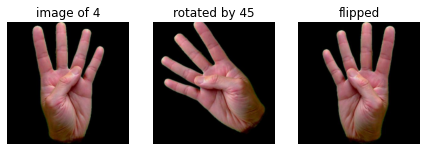

In [ ]:
for i in range (1,384,72):
  plt.figure(figsize=(10, 10))
  ax = plt.subplot(1, 4, 1 )
  plt.imshow(images_augmented[i] / 255)
  plt.axis('off')
  plt.title("image of "+ labels_augmented[i])
  ax = plt.subplot(1, 4, 2 )
  plt.imshow(images_augmented[i+1] / 255)
  plt.axis('off')
  plt.title("rotated by 45")
  ax = plt.subplot(1, 4, 3 )
  plt.imshow(images_augmented[i+2] / 255)
  plt.axis('off')
  plt.title("flipped")



In [ ]:

# print(labels)
x_train, x_test, y_train, y_test = train_test_split(images_augmented, labels_augmented, test_size=0.1 ,random_state= 42 ,stratify = labels_augmented)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05,random_state = 42, stratify = y_train)
print(sorted(y_train))
print(sorted(y_test))
print(sorted(y_val))

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',

# CNN model for Image classification

In [ ]:
x_train = np.array(x_train , dtype=np.float16) / 225.0
x_test = np.array(x_test , dtype=np.float16) / 225.0
x_val = np.array(x_val , dtype=np.float16) / 225.0

x_train = x_train.reshape(-1 , x_train.shape[1] , x_train.shape[2]  , x_train.shape[3])
x_val = x_val.reshape(-1 , x_val.shape[1]  , x_val.shape[2]  ,  x_val.shape[3] )
x_test = x_test.reshape(-1 , x_test.shape[1]  , x_test.shape[2]  ,  x_test.shape[3] )

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)


(6450, 224, 224, 3)
(340, 224, 224, 3)
(755, 224, 224, 3)


In [ ]:

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
y_val = lb.fit_transform(y_val)

y_test.shape

(755, 36)

In [ ]:
# np.save("/content/gdrive/MyDrive/aaaa/x_train.npy", x_train)
# np.save("/content/gdrive/MyDrive/aaaa/y_train.npy", y_train)

# np.save("/content/gdrive/MyDrive/aaaa/x_val.npy", x_val)
# np.save("/content/gdrive/MyDrive/aaaa/y_val.npy", y_val)

# np.save("/content/gdrive/MyDrive/aaaa/x_test.npy", x_test)
# np.save("/content/gdrive/MyDrive/aaaa/y_test.npy", y_test)

In [ ]:

# x_train=np.load("/content/gdrive/MyDrive/aaaa/x_train.npy")
# y_train=np.load("/content/gdrive/MyDrive/aaaa/y_train.npy")

# x_val=np.load("/content/gdrive/MyDrive/aaaa/x_val.npy")
# y_val=np.load("/content/gdrive/MyDrive/aaaa/y_val.npy")

# x_test=np.load("/content/gdrive/MyDrive/aaaa/x_test.npy")
# y_test=np.load("/content/gdrive/MyDrive/aaaa/y_test.npy")

In [ ]:

BATCH_SIZE = 32
EPOCHS = 50
LR = 0.001
learning_rate_reduction = ReduceLROnPlateau(monitor="accuracy", min_lr = LR)
earlystopping = EarlyStopping(monitor ="accuracy" , patience = 20)
callbacks=[earlystopping , learning_rate_reduction]

In [ ]:


with tf.device('/device:GPU:0'):
  asl_model = keras.Sequential()
  asl_model.add(Conv2D(16 , (3,3) , activation="relu" ))
  asl_model.add(MaxPooling2D(pool_size=(2,2)))

  asl_model.add(Conv2D(32 , (3,3) , activation="relu"))
  asl_model.add(MaxPooling2D(pool_size=(2,2)))
  

  asl_model.add(Conv2D(64 , (3,3) , activation="relu"))
  asl_model.add(MaxPooling2D(pool_size=(2,2)))
  asl_model.add(Dropout(0.2))

  asl_model.add(Conv2D(128 , (3,3) , activation="relu"))
  asl_model.add(MaxPooling2D(pool_size=(2,2)))
  asl_model.add(Dropout(0.3))

  asl_model.add(Conv2D(256 , (3,3) , activation="relu"))
  asl_model.add(MaxPooling2D(pool_size=(2,2)))
  asl_model.add(Dropout(0.5))

  asl_model.add(Flatten())
  asl_model.add(Dense(512 , activation="relu"))
  asl_model.add(Dropout(0.4))
  asl_model.add(Dense(36 , activation="softmax"))
  asl_model.compile(optimizer="adam" , loss="categorical_crossentropy" , metrics=["accuracy"])

In [ ]:
with tf.device('/device:GPU:0'):
  history = asl_model.fit(x_train , y_train , validation_data=(x_val,y_val) ,epochs=EPOCHS , batch_size=BATCH_SIZE , callbacks=callbacks)



Epoch 1/50
202/202 [==============================] - 21s 41ms/step - loss: 2.2228 - accuracy: 0.3347 - val_loss: 0.7301 - val_accuracy: 0.7588 - lr: 0.0010
Epoch 2/50
202/202 [==============================] - 7s 36ms/step - loss: 0.7653 - accuracy: 0.7357 - val_loss: 0.2800 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 3/50
202/202 [==============================] - 7s 36ms/step - loss: 0.4464 - accuracy: 0.8372 - val_loss: 0.1760 - val_accuracy: 0.9353 - lr: 0.0010
Epoch 4/50
202/202 [==============================] - 7s 36ms/step - loss: 0.3447 - accuracy: 0.8746 - val_loss: 0.1593 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 5/50
202/202 [==============================] - 7s 36ms/step - loss: 0.2797 - accuracy: 0.8984 - val_loss: 0.1169 - val_accuracy: 0.9559 - lr: 0.0010
Epoch 6/50
202/202 [==============================] - 7s 37ms/step - loss: 0.2343 - accuracy: 0.9118 - val_loss: 0.1015 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 7/50
202/202 [==============================] - 7s 37ms/s

In [ ]:
asl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

0.9879069924354553
0.9970588088035583


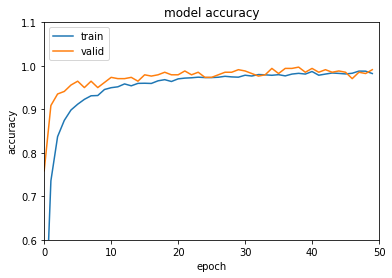

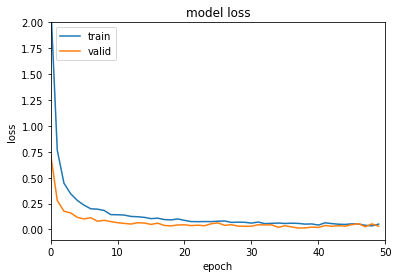

In [ ]:
  # import statistics

  # print(max(history.history['accuracy']))
  # print(max(history.history['val_accuracy']))
  
  plt.plot(history.history['accuracy'])

  plt.plot(history.history['val_accuracy'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.ylim(0.6,1.1)
  plt.xlim(0,50)
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.ylim(-0.1,2)
  plt.xlim(0,50)
  plt.show()

In [ ]:
test_acc = asl_model.evaluate(x_test , y_test)[1]
print("Test_acc = " , test_acc*100 , "%")

24/24 [==============================] - 1s 21ms/step - loss: 0.0516 - accuracy: 0.9815
Test_acc =  98.14569354057312 %
